# Setup


## Function setup

In [2]:
from bs4 import BeautifulSoup, Tag, NavigableString
from collections import defaultdict
import re
from itertools import islice
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from googletrans import Translator

In [3]:
drop_dict_list = [
    'Meine Werkzeuge', 'Namensräume', 'Ansichten', 'Navigation', 'Mitmachen', 'Werkzeuge',
    'Drucken/\u200bexportieren', 'In anderen Projekten', 'In anderen Sprachen'
]

def translate_german_to_english(text):
    translator = Translator(service_urls=['translate.google.com'])
    translated_text = translator.translate(text, src='de', dest='en')
    return translated_text.text

def count_items(html_content):
    # translator = Translator(service_urls=['translate.google.com'])
    soup = BeautifulSoup(html_content, 'html.parser')
    string_soup = str(soup)
    category_dict ={}
    split_pattern = r'(<p><b>(?!<))'
    drop_topic_list = [
        'Meine Werkzeuge', 'Namensräume', 'Ansichten', 'Navigation', 'Mitmachen', 'Werkzeuge',
        'Drucken/\u200bexportieren', 'In anderen Projekten', 'In anderen Sprachen'
    ]
    # Split the text using the regex pattern and preserve the split value
    split_text = re.split(split_pattern, string_soup)

    split_text = [s for s in split_text if s]

    for text in split_text:
        if ':</b>' not in text:
            continue
        current_count = text.count('<a href="/wiki/')
        current_split = text.split(':</b>')
        current_name = current_split[0]
        # current_name = translator.translate(current_name)
        category_dict[current_name] = current_count


    h3_tags = soup.find_all('h3')
    split_h3 = string_soup.split('<h3')

    topic_count = {}
    for i, h3_tag in enumerate(h3_tags):
        topic_title = h3_tag.text.strip()
        if topic_title in drop_topic_list:
            continue
        topic_title = topic_title.replace("\n", " ")
        topic_title = re.sub(r'\s+', ' ', topic_title)
        # topic_title = translator.translate(topic_title)
        if not  isinstance(topic_title,str):
            topic_title = topic_title.text
        # if topic_title == 'Story':
        #     topic_title = 'History'
        # if topic_title == 'Gesellschaft':
        #     topic_title = 'Society'
        current_passage = split_h3[(i + 1)]
        current_count = current_passage.count('<a href="/wiki/')
        topic_count[topic_title] = current_count


    return category_dict, topic_count

In [7]:

with open('data/data_files/landingpages_html/excellent_html_full.html', 'r', encoding='utf-8') as file:
    html_content = file.read()

excellent_cats, excellent_topics = count_items(html_content)
for key in drop_dict_list:
    excellent_topics.pop(key, None)

with open('data/data_files/landingpages_html/readworthy_html_full.html', 'r', encoding='utf-8') as file:
    html_content = file.read()

readworthy_cats,readworthy_topics = count_items(html_content)
for key in drop_dict_list:
    readworthy_topics.pop(key, None)    



# Results

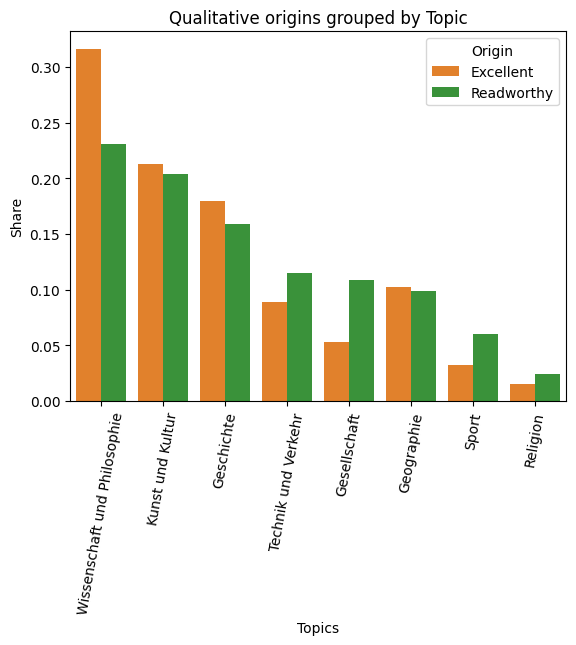

In [6]:
# Convert the dictionaries to pandas DataFrames
read_df = pd.DataFrame(list(readworthy_topics.items()), columns=['Topic', 'Value'])
read_df['Source'] = 'Dict 1'
exc_df = pd.DataFrame(list(excellent_topics.items()), columns=['Topic', 'Value'])
exc_df['Source'] = 'Dict 2'

# Calculate the total count for each dataframe
total_count_read = read_df['Value'].sum()
total_count_exc = exc_df['Value'].sum()

# Calculate the shares of the total for each dataframe
read_df['share'] = read_df['Value'] / total_count_read
exc_df['share'] = exc_df['Value'] / total_count_exc

# Add a 'source' column to identify the dataframes
exc_df['Origin'] = 'Excellent'
read_df['Origin'] = 'Readworthy'

# Concatenate the dataframes
combined_df = pd.concat([ exc_df,read_df], axis=0)

sorting_order = read_df.sort_values('share',ascending=False)['Topic'].tolist()
current_palette = sns.color_palette()
custom_palette = [current_palette[1], current_palette[2]]
# Create a seaborn barplot
sns.barplot(data=combined_df, x='Topic', y='share', hue='Origin',order = sorting_order,palette=custom_palette)

# Rotate x-axis labels
plt.xticks(rotation=80)
plt.title('Qualitative origins grouped by Topic')
# Set axis labels
plt.xlabel('Topics')
plt.ylabel('Share')

# Show the plot
plt.show()